In [1]:
from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = loadStooqData('cpiypl.m','1991-01-01')

In [3]:
def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/(1/period)
    u = a/k
    resid = res.resid
    sig = np.sqrt(np.mean(resid**2))
    sig = np.round(sig,4)

    return (u,sig,k)


,Zamkniecie
count,228.000000
mean,0.028293
std,0.030898
min,-0.016129
25%,0.011681
50%,0.024205
75%,0.038499
max,0.164667


<AxesSubplot:ylabel='Zamkniecie'>

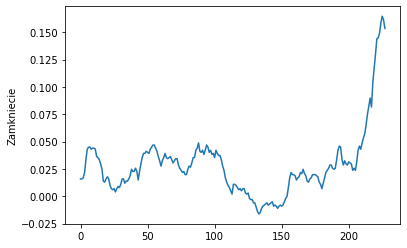

In [20]:
cpi = data['2004-01-01':'2022-12-31'] / 100
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
display(cpi.describe())
sns.lineplot(data=cpi['Zamkniecie'])


In [5]:
u,sig,k = ornstein_uhlenbeck_params(cpi,1/12)
print(u)
print(sig)
print(k)

0.06847778559514779
0.0044
-0.002294295727823803


In [6]:
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=u,sigma=sig,theta=k)

In [7]:
length = 180
scenarios = simulator.scenarios(0.16,1,1000,length)

In [8]:
perc = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=0)

In [9]:
def fanchart(hist,percentiles):
    x = np.linspace(0,length+1,length+1)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[4], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[5], color='blue', alpha=0.2)
    ax.fill_between(x=x,y1=percentiles[2],y2=percentiles[6], color='blue', alpha=0.3)
    ax.plot(percentiles[3],color='blue')

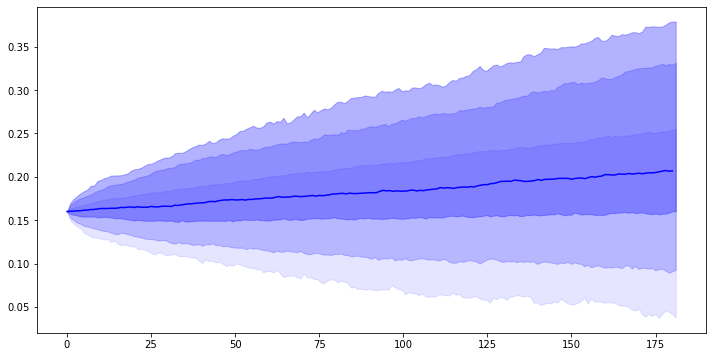

In [10]:
fanchart(cpi,perc)

In [11]:
def percentile_summary(perc):
    perc_dict = {'perc': ['1','5','25','50','75','95','99'],
                 '1': perc[:,12],
                 '2': perc[:,24],
                 '3': perc[:,36],
                 '5': perc[:,60],
                 '10': perc[:,120],
                 '15': perc[:,180]
                 }
    
    perc_summary = pd.DataFrame(perc_dict)
    perc_summary.set_index('perc', inplace=True)
    return perc_summary
percentile_summary(perc)

,1,2,3,5,10,15
perc,,,,,,
1,0.128196,0.114378,0.107595,0.091548,0.061710,0.037927
5,0.137123,0.128346,0.123083,0.114223,0.103004,0.092648
25,0.153387,0.149309,0.148563,0.149597,0.153355,0.160209
50,0.163465,0.164976,0.168858,0.175540,0.188790,0.206942
75,0.174102,0.180540,0.187005,0.200342,0.228067,0.254810
95,0.189237,0.201891,0.216014,0.234685,0.278744,0.331627
99,0.199432,0.214889,0.231937,0.263724,0.322321,0.379203


In [12]:
endog = cpi['Zamkniecie'].iloc[1:] #sm.add_constant(cpi['Zamkniecie'],prepend=True).iloc[1:]
exog = cpi['Zamkniecie'].iloc[:-1]
cpi_model = sm.tsa.MarkovRegression(endog,k_regimes=2, exog=exog, switching_variance=True)
res = cpi_model.fit()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:             Zamkniecie   No. Observations:                  227
Model:               MarkovRegression   Log Likelihood                     nan
Date:                Sun, 17 Sep 2023   AIC                                nan
Time:                        21:32:09   BIC                                nan
Sample:                             0   HQIC                               nan
                                - 227                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.8562        nan        nan        nan         nan         nan
x1          1007.1127        nan        nan        nan         nan         nan
sigma2      7.017e-06        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6388        nan        nan        nan         nan         nan
x1          1944.1320        nan        nan        nan         nan         nan
sigma2        60.5044        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        1.0000        nan        nan        nan         nan         nan
p[1->0]             0        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [14]:
res.params


p[0->0]         1.000000
p[1->0]         0.000000
const[0]      -24.856163
const[1]       -3.638782
x1[0]        1007.112695
x1[1]        1944.131965
sigma2[0]       0.000007
sigma2[1]      60.504373
dtype: float64

In [15]:
#regime1
period = 12
a = res.params['const[1]']
b = res.params['x1[1]']
k = (1 -b)/(1/period)
u = a/k
print(u)
print(k)

0.00015605313396862332
-23317.583582733252


<AxesSubplot:>

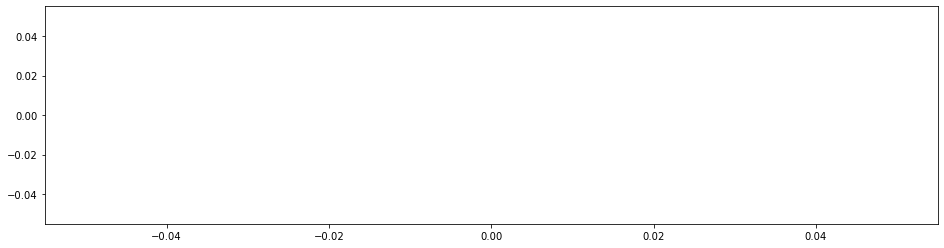

In [16]:
res.smoothed_marginal_probabilities[0].plot(figsize=(16,4))
res.smoothed_marginal_probabilities[1].plot(figsize=(16,4))
#res.smoothed_marginal_probabilities[2].plot(figsize=(16,4))